In [11]:
# -----------------------------------------------
# 1. Import Required Libraries
# -----------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [12]:
# -----------------------------------------------
# 2. Load Dataset
# -----------------------------------------------
train_path = r"C:\Users\avina\Downloads\archive (4)\fraudTrain.csv"
test_path = r"C:\Users\avina\Downloads\archive (4)\fraudTest.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

print("Train Shape:", train_data.shape)
print("Test Shape:", test_data.shape)


Train Shape: (1296675, 23)
Test Shape: (555719, 23)


In [17]:
# -----------------------------------------------
# 3. Data Preprocessing
# -----------------------------------------------
# Drop columns not useful for modeling
drop_cols = ['trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 
             'city', 'state', 'zip', 'dob', 'trans_num', 'merchant', 'job', 'unix_time', 'merch_lat', 'merch_long']

# Drop only columns that exist in the DataFrame
train_data = train_data.drop(columns=[col for col in drop_cols if col in train_data.columns])
test_data = test_data.drop(columns=[col for col in drop_cols if col in test_data.columns])

# Convert categorical feature 'category' using one-hot encoding if it exists
if 'category' in train_data.columns:
    train_data = pd.get_dummies(train_data, columns=['category'], drop_first=True)
if 'category' in test_data.columns:
    test_data = pd.get_dummies(test_data, columns=['category'], drop_first=True)

# Ensure test and train have same columns
train_data, test_data = train_data.align(test_data, join='inner', axis=1)

# Split features and target
X_train = train_data.drop('is_fraud', axis=1)
y_train = train_data['is_fraud']
X_test = test_data.drop('is_fraud', axis=1)
y_test = test_data['is_fraud']

# Encode categorical 'gender' column
X_train['gender'] = X_train['gender'].map({'F': 0, 'M': 1})
X_test['gender'] = X_test['gender'].map({'F': 0, 'M': 1})

# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [21]:
# -----------------------------------------------
# 4. Train the Random Forest Model 
# -----------------------------------------------
import time

start_time = time.time()

model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)

end_time = time.time()
print(f"✅ Model trained in {end_time - start_time:.2f} seconds")


✅ Model trained in 64.00 seconds


In [22]:
# -----------------------------------------------
# 5. Predictions & Evaluation
# -----------------------------------------------
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Classification report
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))


🔍 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.75      0.54      0.63      2145

    accuracy                           1.00    555719
   macro avg       0.88      0.77      0.81    555719
weighted avg       1.00      1.00      1.00    555719



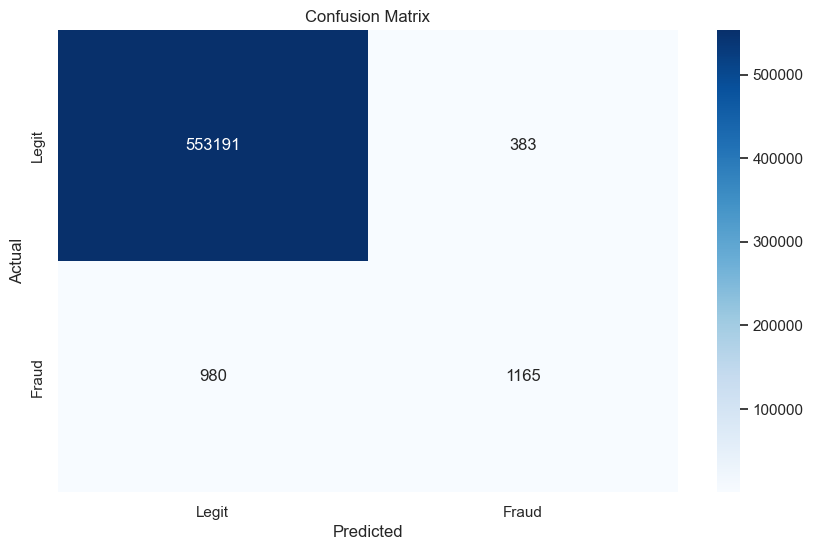

In [23]:
# -----------------------------------------------
# 6. Confusion Matrix
# -----------------------------------------------
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


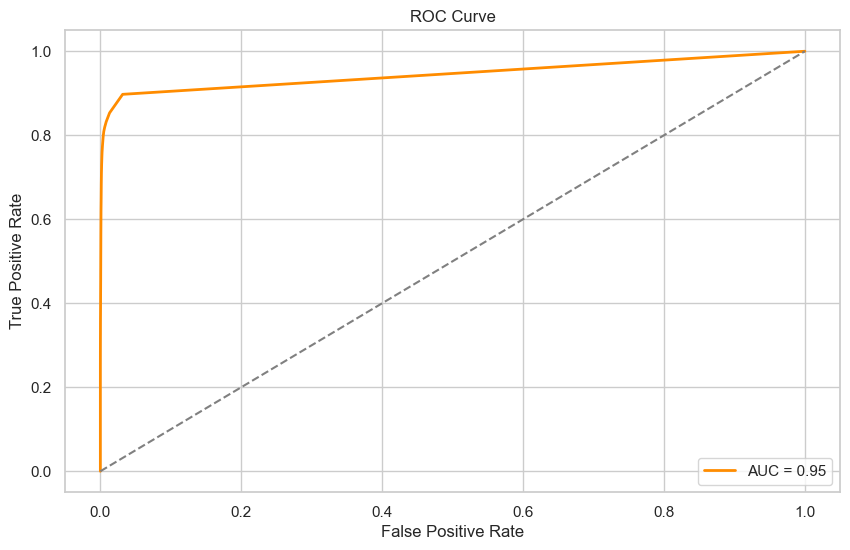

In [24]:
# -----------------------------------------------
# 7. ROC Curve & AUC Score
# -----------------------------------------------
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


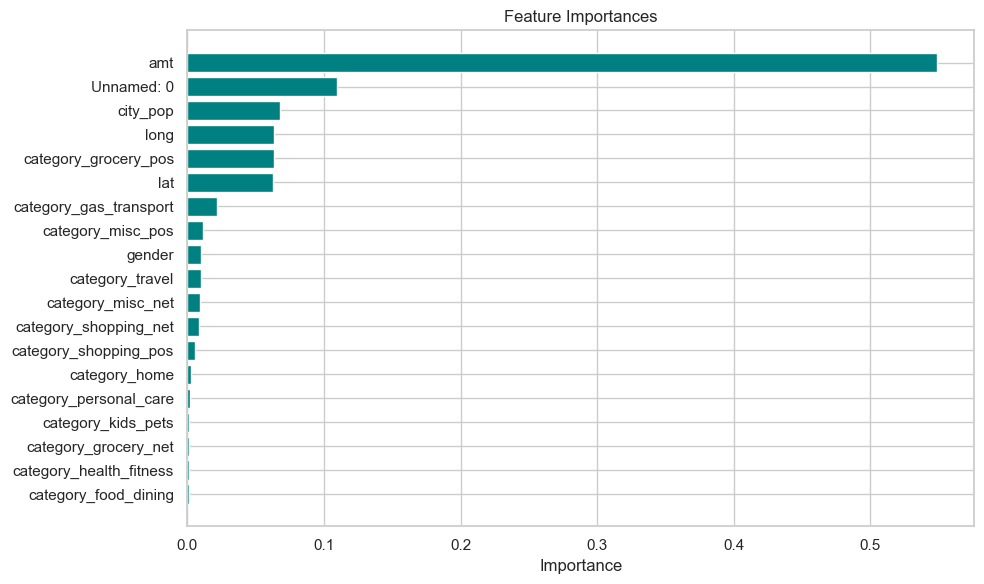

In [25]:
# -----------------------------------------------
# 8. Feature Importance
# -----------------------------------------------
importances = model.feature_importances_
indices = np.argsort(importances)
features = X_train.columns

plt.barh(range(len(indices)), importances[indices], color='teal')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [26]:
# -----------------------------------------------
# 9. Misclassification Analysis
# -----------------------------------------------
false_positives = (y_pred == 1) & (y_test == 0)
false_negatives = (y_pred == 0) & (y_test == 1)

print(f"❌ False Positives: {false_positives.sum()}")
print(f"❌ False Negatives: {false_negatives.sum()}")

print("\nExamples of False Positives:")
display(test_data[false_positives].head())

print("\nExamples of False Negatives:")
display(test_data[false_negatives].head())


❌ False Positives: 383
❌ False Negatives: 980

Examples of False Positives:


,Unnamed: 0,amt,gender,lat,long,city_pop,is_fraud,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
2071,2071,722.94,F,44.2320,-74.4905,6120,0,False,False,False,False,False,False,False,True,False,False,False,False,False
3944,3944,912.03,F,40.8295,-72.6473,3255,0,False,False,False,False,False,False,False,False,False,False,False,True,False
6260,6260,844.81,M,31.6453,-90.1801,1196,0,False,False,False,False,False,False,False,False,False,False,False,True,False
6539,6539,1084.13,F,42.8250,-124.4409,217,0,False,False,False,False,False,False,False,False,False,False,True,False,False
6546,6546,885.07,M,32.7004,-97.6039,13602,0,False,False,False,False,False,False,False,True,False,False,False,False,False



Examples of False Negatives:


,Unnamed: 0,amt,gender,lat,long,city_pop,is_fraud,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
1685,1685,24.84,F,31.8599,-102.7413,23,1,False,False,False,False,True,False,False,False,False,False,False,False,False
1781,1781,620.33,M,42.5545,-90.3508,1306,1,False,False,False,False,False,False,False,False,False,False,False,False,False
1784,1784,1077.69,M,30.4590,-90.9027,71335,1,False,False,False,False,False,False,False,False,False,False,True,False,False
1857,1857,842.65,F,31.8599,-102.7413,23,1,False,False,False,False,False,False,False,False,False,False,False,True,False
1891,1891,22.55,F,27.6330,-80.4031,105638,1,False,False,False,False,True,False,False,False,False,False,False,False,False
